# Seasonal analysis

## Initial setup

### Load modules

In [1]:
# modules in this package
import load_and_preprocess as lp
import analysis as at
import bic_and_aic as ba
import plot_tools as pt
import file_io as io
import numpy as np
import xarray as xr
import density
import gmm
# plotting tools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib as mpl
import cmocean
# os tools
import os.path

# suppress a particular warning
import warnings
warnings.filterwarnings('ignore', 'RuntimeWarning: All-NaN slice encountered')

### Set runtime parameters (file locations, etc.)

In [2]:
# set locations and names
descrip = 'WeddellOnly' # extra description for filename
data_location = '../../so-chic-data/' # input data location
classified_data_location = 'models/profiles_-65to80lon_-85to-30lat_20to1000depth_5K_allDomain_revised.nc'
ploc = 'plots/plots_WeddellClassOnly_top1000m_K04_forAGU22_and_OSpaper/'
#ploc = 'tests/'
dloc = 'models/'

# if plot directory doesn't exist, create it
if not os.path.exists(ploc):
    os.makedirs(ploc)

# save the processed output as a NetCDF file?
saveOutput = False

# number of PCA components (roughly 95%)
n_pca = 6

# make decision about n_components_selected (iterative part of analysis)
n_components_selected = 4

#longitude and latitude range
lon_min = -65
lon_max =  80
lat_min = -80
lat_max = -45
# depth range
zmin = 20.0
zmax = 1000.0
# density range
sig0range = (26.6, 28.0)

# temperature and salinity ranges for plotting
lon_range=(lon_min, lon_max)
lat_range=(lat_min, lat_max)
Trange=(-2.2, 6.0)
Srange=(33.5, 35.0)

# create filename for saving GMM and saving labelled profiles
pca_fname = dloc + 'pca_' + str(int(lon_min)) + 'to' + str(int(lon_max)) + 'lon_' + str(int(lat_min)) + 'to' + str(int(lat_max)) + 'lat_' + str(int(zmin)) + 'to' + str(int(zmax)) + 'depth_' + str(int(n_pca)) + descrip
gmm_fname = dloc + 'gmm_' + str(int(lon_min)) + 'to' + str(int(lon_max)) + 'lon_' + str(int(lat_min)) + 'to' + str(int(lat_max)) + 'lat_' + str(int(zmin)) + 'to' + str(int(zmax)) + 'depth_' + str(int(n_components_selected)) + 'K_' + descrip
fname = dloc + 'profiles_' + str(int(lon_min)) + 'to' + str(int(lon_max)) + 'lon_' + str(int(lat_min)) + 'to' + str(int(lat_max)) + 'lat_' + str(int(zmin)) + 'to' + str(int(zmax)) + 'depth_' + str(int(n_components_selected)) + 'K_' + descrip + '.nc'

# colormap
colormap = plt.get_cmap('Dark2', n_components_selected)
colormap_cividis = plt.get_cmap('cividis', 20)

### Load classified profile data

In [3]:
dfp = xr.open_dataset("weddell_classified_n04.nc")

### Interpolate onto density surfaces

In [4]:
# regrid onto finer vertical pressure grid
dfp = lp.regrid_onto_more_vertical_levels(dfp, zmin=20, zmax=1000)

# interpolate onto density surfaces
dfp = lp.regrid_onto_density_levels(dfp, np.linspace(27.4, 27.8, 5))
dfp

load_and_preprocess.regrid_onto_more_vertical_levels
load_and_preprocess.regrid_onto_density_levels


<xarray.Dataset>
Dimensions:        (profile: 28397, depth: 21, CLASS: 4, depth_mid: 20, depth_highz: 50, sig0_levs: 5)
Coordinates:
  * profile        (profile) int64 13 14 15 16 ... 142282 142301 142320 142330
    lon            (profile) float64 ...
    lat            (profile) float64 ...
  * depth          (depth) float64 20.0 40.0 60.0 80.0 ... 820.0 910.0 1e+03
    time           (profile) datetime64[ns] ...
    year           (profile) int64 ...
    month          (profile) int64 ...
  * CLASS          (CLASS) int64 0 1 2 3
  * depth_mid      (depth_mid) float64 30.0 50.0 70.0 90.0 ... 775.0 865.0 955.0
  * depth_highz    (depth_highz) float64 20.0 40.0 60.0 ... 960.0 980.0 1e+03
  * sig0_levs      (sig0_levs) float64 27.4 27.5 27.6 27.7 27.8
Data variables: (12/28)
    prof_date      (profile) float64 ...
    prof_YYYYMMDD  (profile) float64 ...
    prof_HHMMSS    (profile) float64 ...
    sig0           (profile, depth) float64 ...
    prof_SA        (profile, depth) float64 ...
    prof_CT        (profile, depth) float64 ...
    ...             ...
    ct_on_highz    (profile, depth_highz) float64 -0.1931 -0.8729 ... 1.466
    sa_on_highz    (profile, depth_highz) float64 33.58 33.82 ... 34.9 34.9
    sig0_on_highz  (profile, depth_highz) float64 26.84 27.07 ... 27.8 27.8
    ct_on_sig0     (profile, sig0_levs) float64 -1.437 -1.281 ... 1.901 1.496
    sa_on_sig0     (profile, sig0_levs) float64 34.21 34.34 34.5 ... 34.81 34.9
    z_on_sig0      (profile, sig0_levs) float64 63.96 94.19 ... 400.5 961.5

In [5]:
# select the top pressure level for plotting purposes
df1D = dfp.isel(depth=0)

## Map out individual seasons

Helper function to add season as a coordinate

In [6]:
def add_season_coordinate(dfp):
    
    import xarray as xr
    
    nsize = dfp.profile.size
    month = dfp.month.values
    season = np.zeros((nsize,), dtype='int')
    
    # assign season based on the month (1=DJF, 2=MAM, 3=JJA, 4=SON)
    for i in range(nsize):
        if (month[i]==12 or month[i]==1 or month[i]==2):
            season[i] = 1
        elif (month[i]==3 or month[i]==4 or month[i]==5):
            season[i] = 2
        elif (month[i]==6 or month[i]==7 or month[i]==8):
            season[i] = 3
        elif (month[i]==9 or month[i]==10 or month[i]==11):
            season[i] = 4
        else:
            season[i] = None

    # add season to DataArray
    dseason = xr.DataArray(season, dims=['profile'])
    dfp['season'] = dseason
    dfp = dfp.set_coords({'season'})
    
    return dfp

In [7]:
dfp = add_season_coordinate(dfp)
dfp

<xarray.Dataset>
Dimensions:        (profile: 28397, depth: 21, CLASS: 4, depth_mid: 20, depth_highz: 50, sig0_levs: 5)
Coordinates:
  * profile        (profile) int64 13 14 15 16 ... 142282 142301 142320 142330
    lon            (profile) float64 -26.44 -22.37 -17.38 ... 53.09 53.33 53.76
    lat            (profile) float64 -55.98 -56.81 -57.51 ... -58.46 -58.59
  * depth          (depth) float64 20.0 40.0 60.0 80.0 ... 820.0 910.0 1e+03
    time           (profile) datetime64[ns] 1973-01-11T12:00:00 ... 2020-10-1...
    year           (profile) int64 1973 1973 1973 1973 ... 2020 2020 2020 2020
    month          (profile) int64 1 1 1 1 1 1 1 1 1 1 ... 8 8 8 9 9 9 9 9 10 10
  * CLASS          (CLASS) int64 0 1 2 3
  * depth_mid      (depth_mid) float64 30.0 50.0 70.0 90.0 ... 775.0 865.0 955.0
  * depth_highz    (depth_highz) float64 20.0 40.0 60.0 ... 960.0 980.0 1e+03
  * sig0_levs      (sig0_levs) float64 27.4 27.5 27.6 27.7 27.8
    season         (profile) int64 1 1 1 1 1 1 1 1 1 1 1 ... 3 3 3 4 4 4 4 4 4 4
Data variables: (12/28)
    prof_date      (profile) float64 7.206e+05 7.206e+05 ... 7.381e+05 7.381e+05
    prof_YYYYMMDD  (profile) float64 1.973e+07 1.973e+07 ... 2.02e+07 2.02e+07
    prof_HHMMSS    (profile) float64 1.2e+05 1.2e+05 ... 4.45e+04 5.19e+04
    sig0           (profile, depth) float64 ...
    prof_SA        (profile, depth) float64 ...
    prof_CT        (profile, depth) float64 ...
    ...             ...
    ct_on_highz    (profile, depth_highz) float64 -0.1931 -0.8729 ... 1.466
    sa_on_highz    (profile, depth_highz) float64 33.58 33.82 ... 34.9 34.9
    sig0_on_highz  (profile, depth_highz) float64 26.84 27.07 ... 27.8 27.8
    ct_on_sig0     (profile, sig0_levs) float64 -1.437 -1.281 ... 1.901 1.496
    sa_on_sig0     (profile, sig0_levs) float64 34.21 34.34 34.5 ... 34.81 34.9
    z_on_sig0      (profile, sig0_levs) float64 63.96 94.19 ... 400.5 961.5

## T-S histograms by season

### TS MLD DJF

plot_tools.plot_hist_map


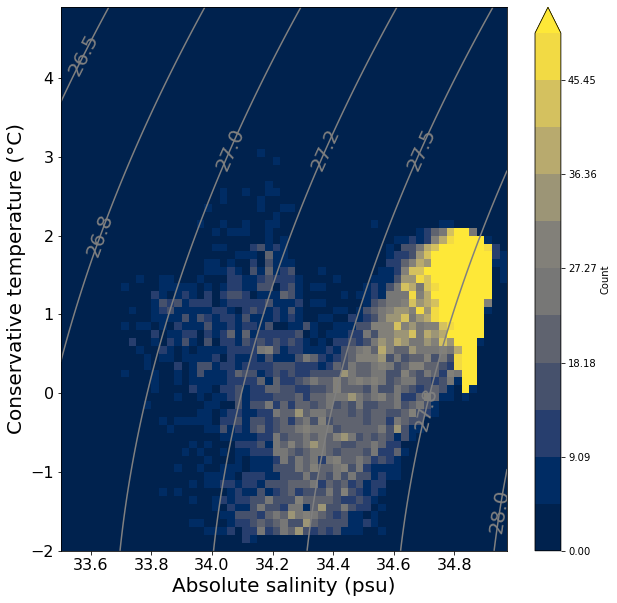

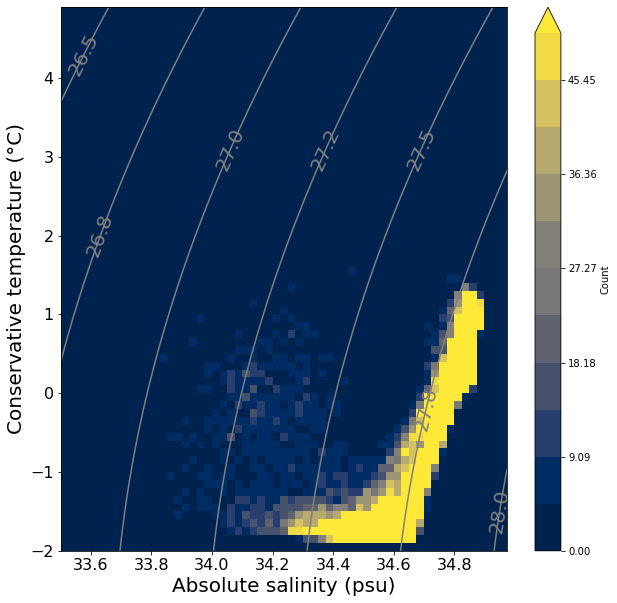

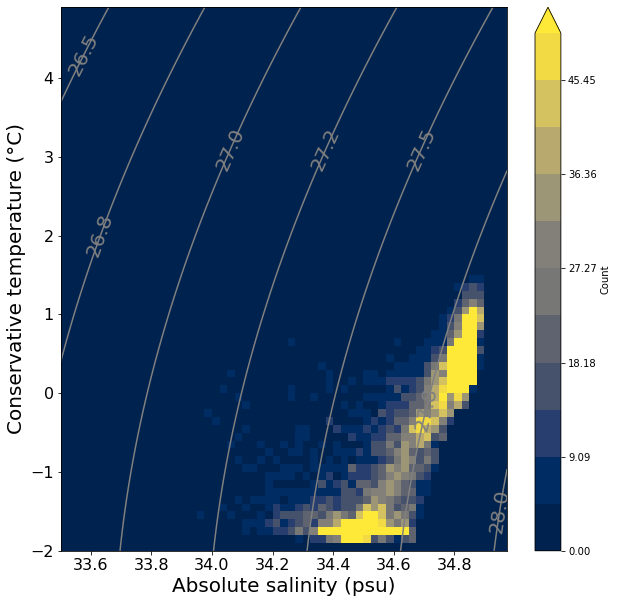

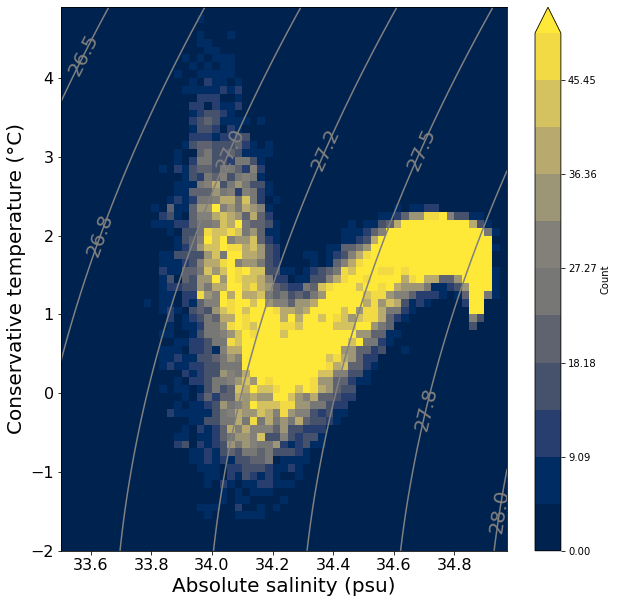

In [8]:
pt.plot_hist_TS(ploc, dfp.where(dfp.season==1, drop=True), n_components_selected,
                sbins = np.arange(33.5, 35.0, 0.025), 
                tbins = np.arange(-2, 5, 0.1),
                crange=[0,50],
                vartype='count',
                colormap=colormap_cividis,
                moreText='DJF',
                fs=20)

### T-S MLD MAM

plot_tools.plot_hist_map


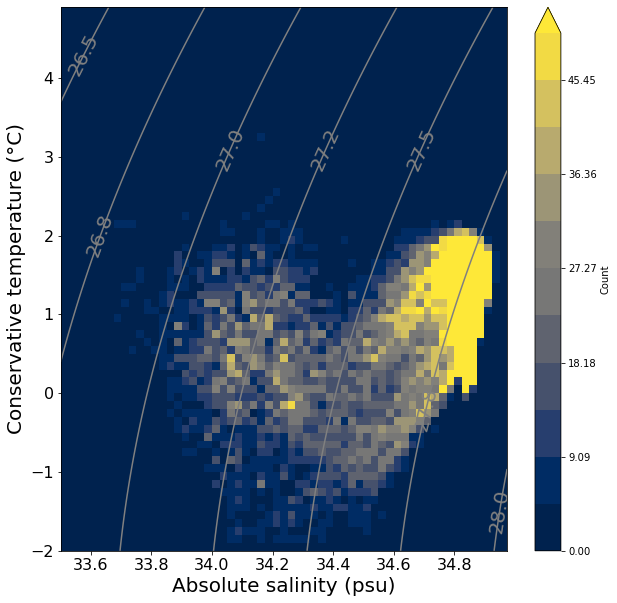

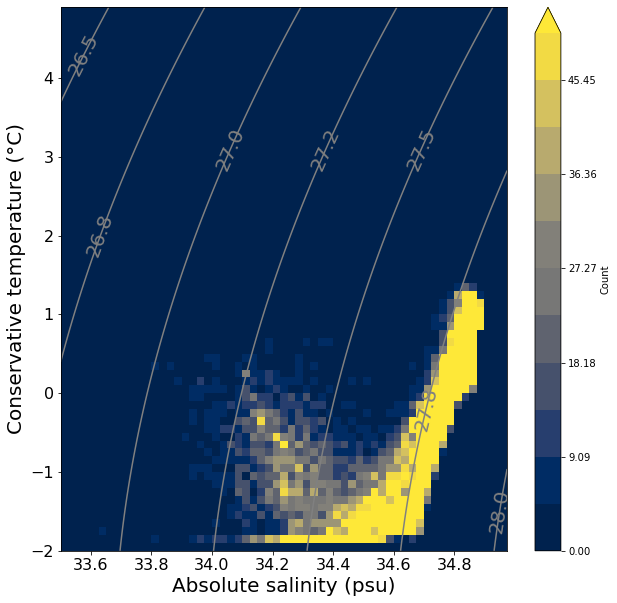

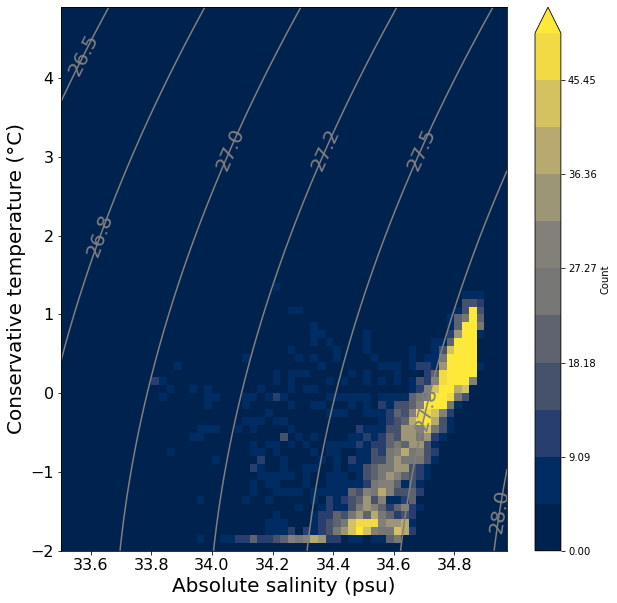

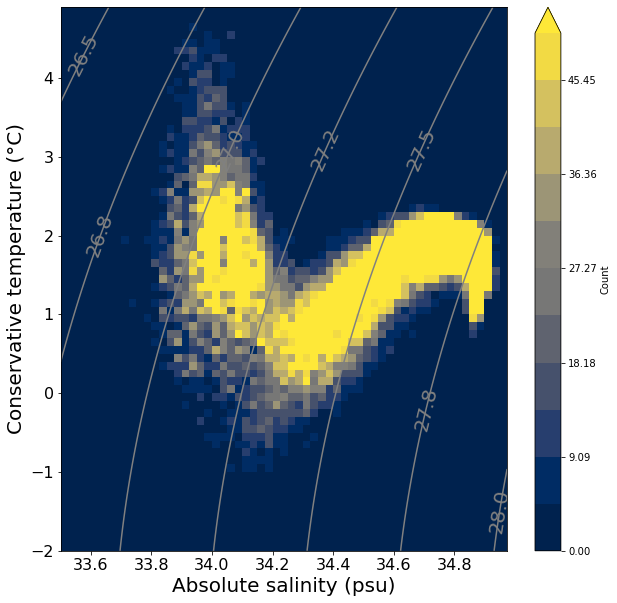

In [9]:
pt.plot_hist_TS(ploc, dfp.where(dfp.season==2, drop=True), n_components_selected,
                sbins = np.arange(33.5, 35.0, 0.025), 
                tbins = np.arange(-2, 5, 0.1),
                crange=[0,50],
                vartype='count',
                colormap=colormap_cividis,
                moreText='MAM',
                fs=20)

### T-S MLD JJA

plot_tools.plot_hist_map


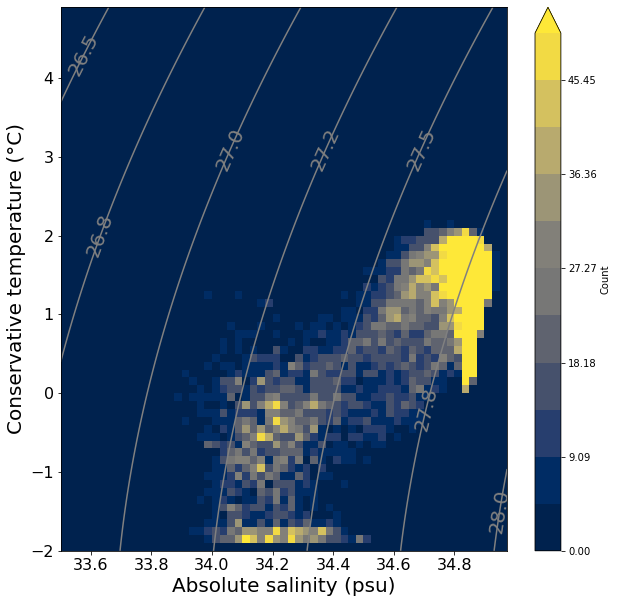

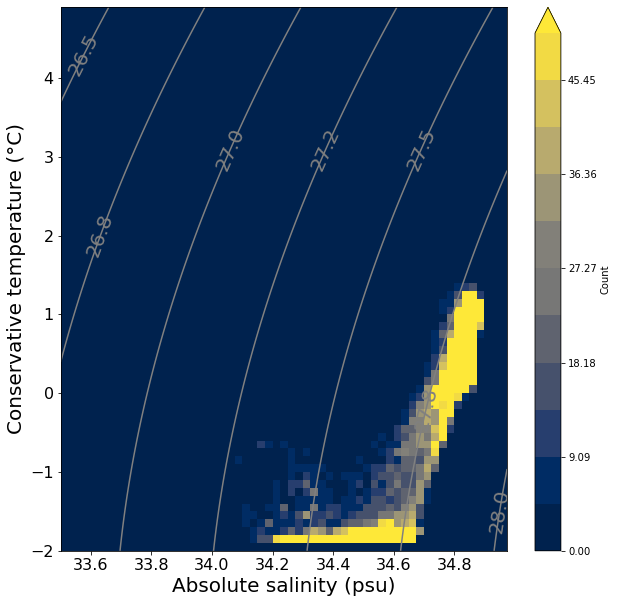

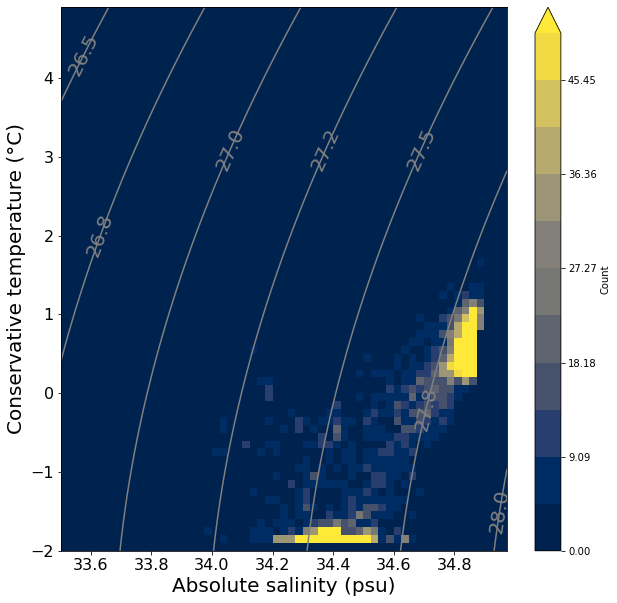

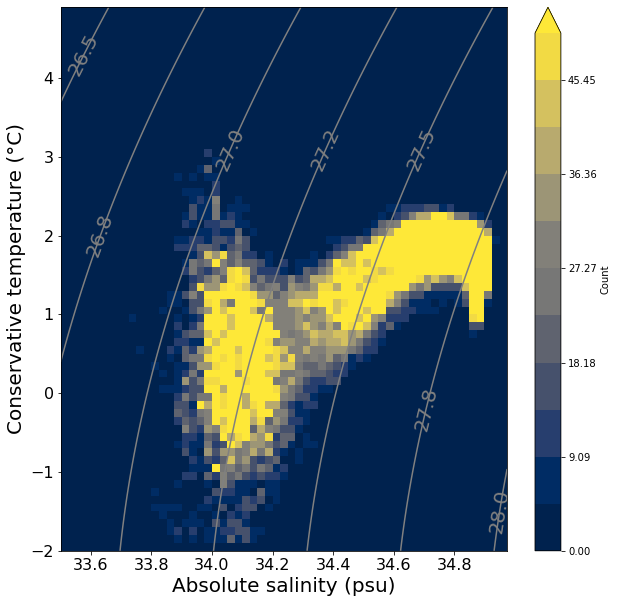

In [10]:
pt.plot_hist_TS(ploc, dfp.where(dfp.season==3, drop=True), n_components_selected,
                sbins = np.arange(33.5, 35.0, 0.025), 
                tbins = np.arange(-2, 5, 0.1),
                crange=[0,50],
                vartype='count',
                colormap=colormap_cividis,
                moreText='JJA',
                fs=20)

### T-S MLD SON

plot_tools.plot_hist_map


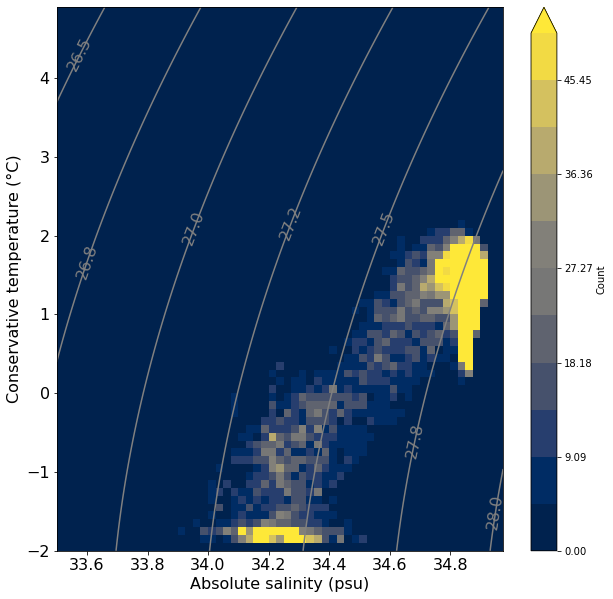

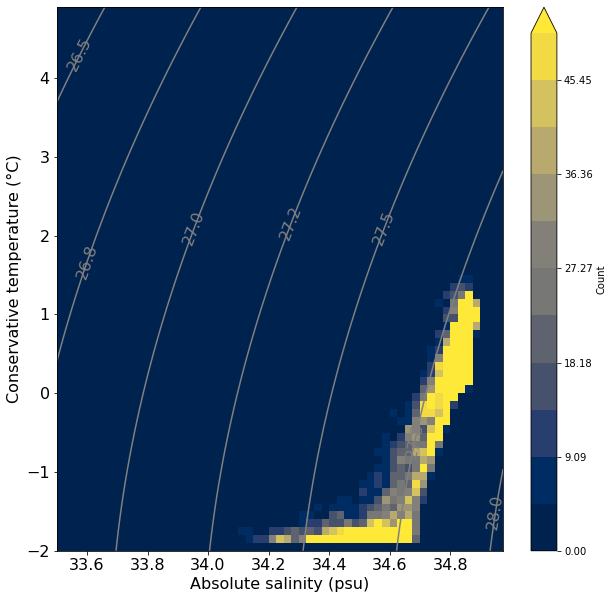

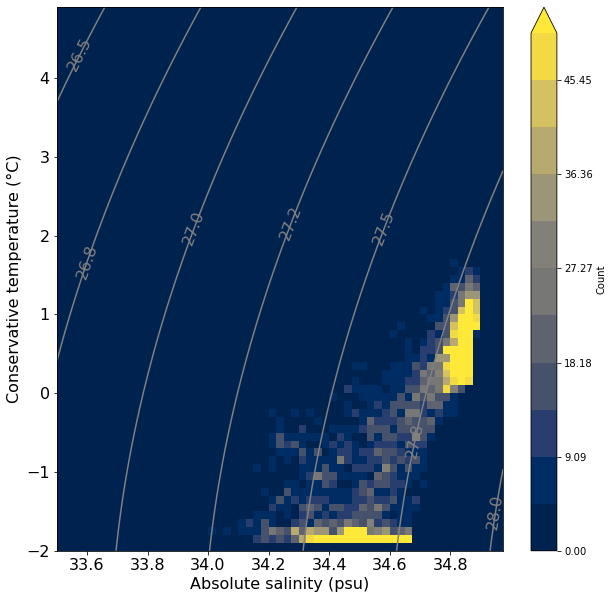

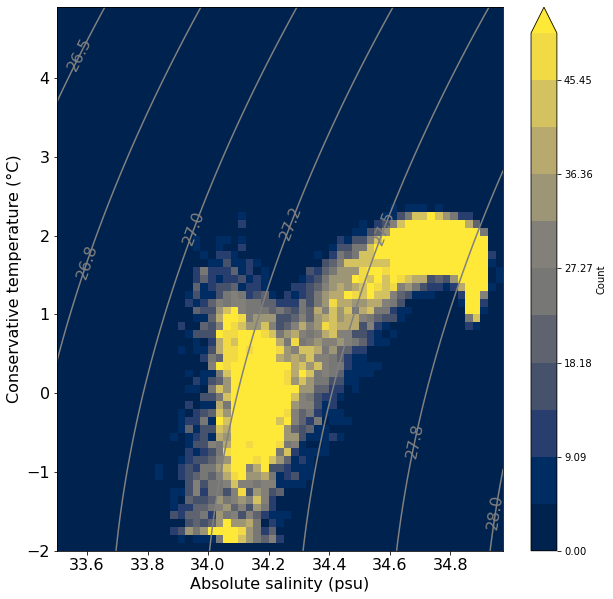

In [11]:
pt.plot_hist_TS(ploc, dfp.where(dfp.season==4, drop=True), n_components_selected,
                sbins = np.arange(33.5, 35.0, 0.025), 
                tbins = np.arange(-2, 5, 0.1),
                crange=[0,50],
                vartype='count',
                colormap=colormap_cividis,
                moreText='SON')

## Profile stats by class and season

### DJF

plot_tools.plot_class_vertical_structures
plot_tools.plot_many_profiles


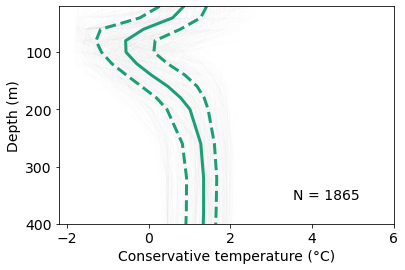

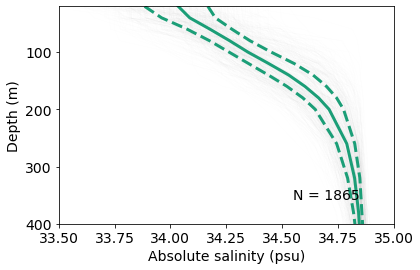

plot_tools.plot_many_profiles


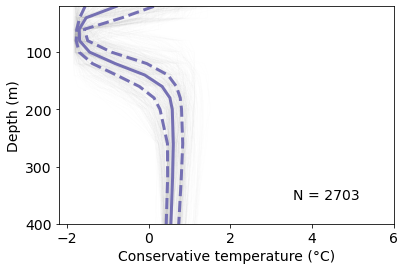

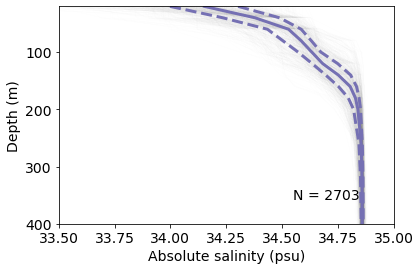

plot_tools.plot_many_profiles


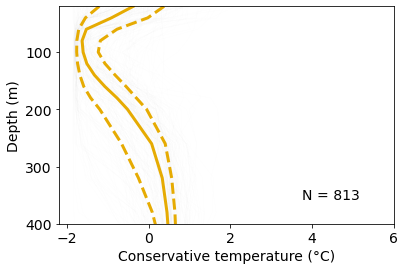

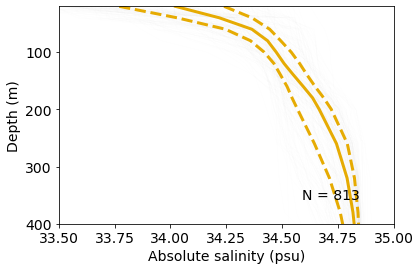

plot_tools.plot_many_profiles


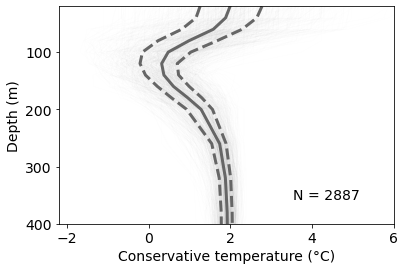

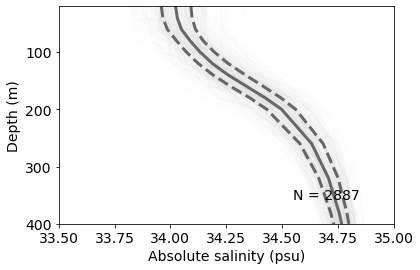

In [12]:
# plot T, S vertical structure of the classes
pt.plot_class_vertical_structures(ploc, dfp.where(dfp.season==1, drop=True), 
                                  n_components_selected, 
                                  colormap,
                                  zmin=zmin, 
                                  zmax=400,
                                  Tmin=Trange[0], 
                                  Tmax=Trange[1],
                                  Smin=Srange[0], 
                                  Smax=Srange[1],
                                  frac=0.25, 
                                  description='DJF',
                                  withDensity=False)

### MAM

plot_tools.plot_class_vertical_structures
plot_tools.plot_many_profiles


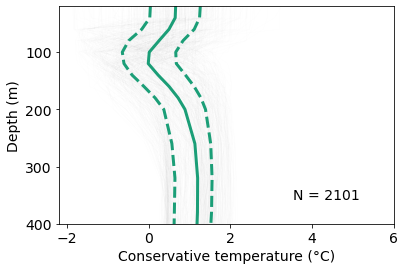

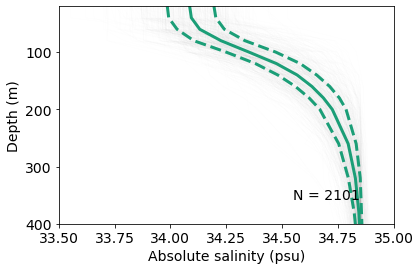

plot_tools.plot_many_profiles


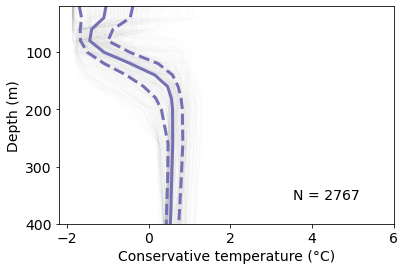

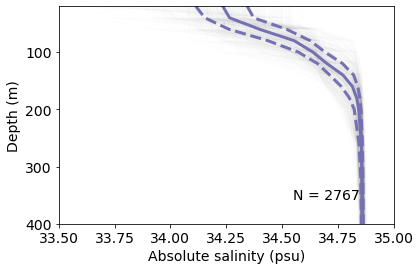

plot_tools.plot_many_profiles


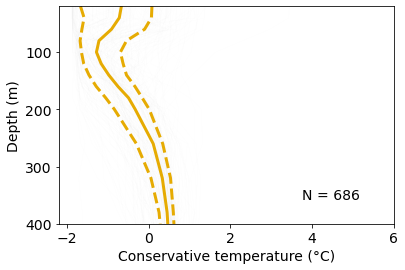

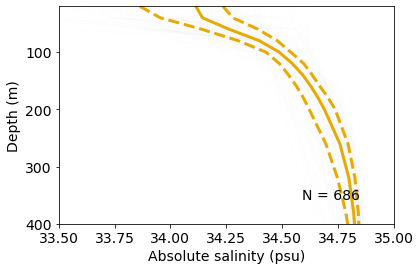

plot_tools.plot_many_profiles


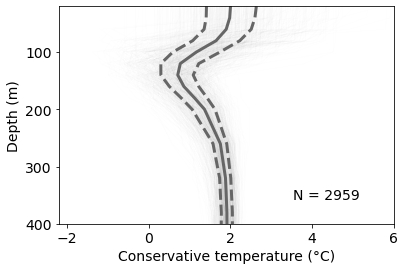

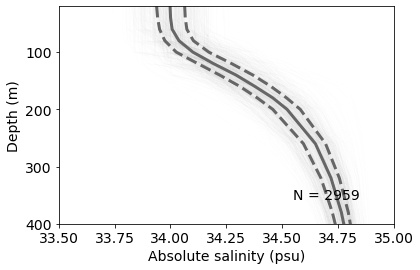

In [13]:
# plot T, S vertical structure of the classes
pt.plot_class_vertical_structures(ploc, dfp.where(dfp.season==2, drop=True), 
                                  n_components_selected, 
                                  colormap,
                                  zmin=zmin, 
                                  zmax=400,
                                  Tmin=Trange[0], 
                                  Tmax=Trange[1],
                                  Smin=Srange[0], 
                                  Smax=Srange[1],
                                  frac=0.25, 
                                  description='MAM',
                                  withDensity=False)

### JJA

plot_tools.plot_class_vertical_structures
plot_tools.plot_many_profiles


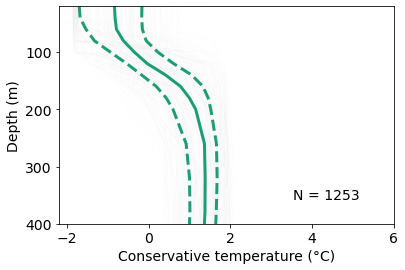

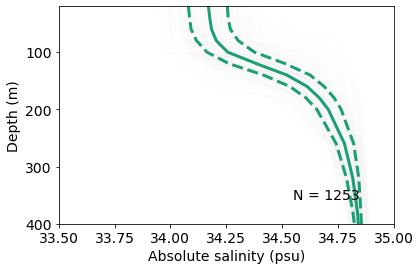

plot_tools.plot_many_profiles


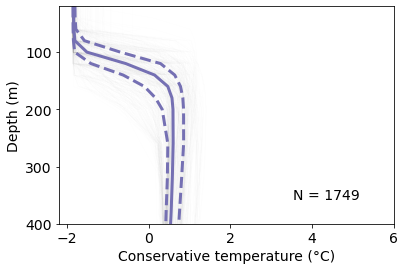

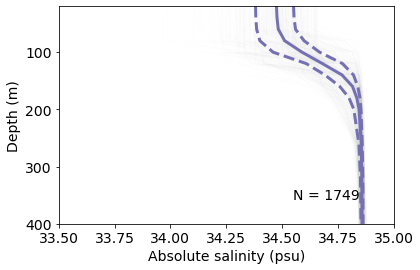

plot_tools.plot_many_profiles


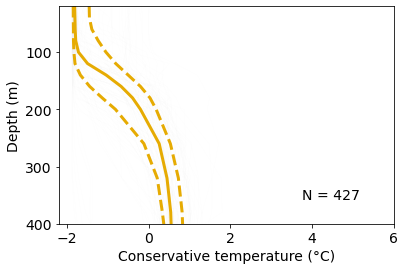

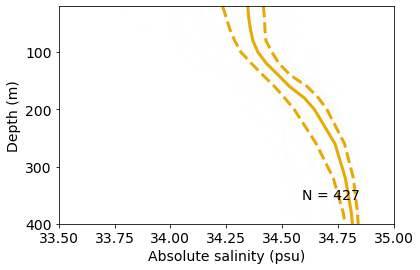

plot_tools.plot_many_profiles


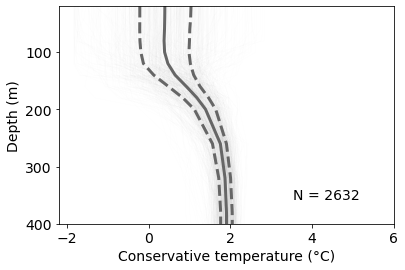

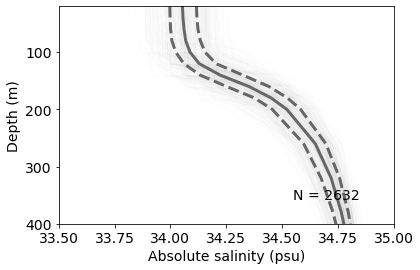

In [14]:
# plot T, S vertical structure of the classes
pt.plot_class_vertical_structures(ploc, dfp.where(dfp.season==3, drop=True), 
                                  n_components_selected, 
                                  colormap,
                                  zmin=zmin, 
                                  zmax=400,
                                  Tmin=Trange[0], 
                                  Tmax=Trange[1],
                                  Smin=Srange[0], 
                                  Smax=Srange[1],
                                  frac=0.25, 
                                  description='JJA',
                                  withDensity=False)

### SON

plot_tools.plot_class_vertical_structures
plot_tools.plot_many_profiles


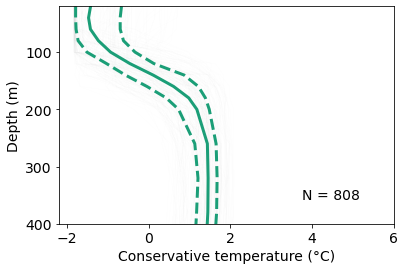

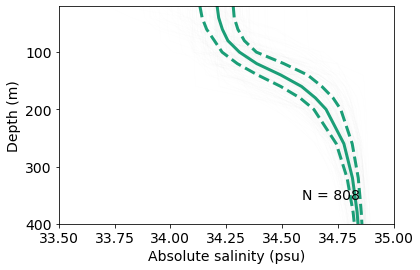

plot_tools.plot_many_profiles


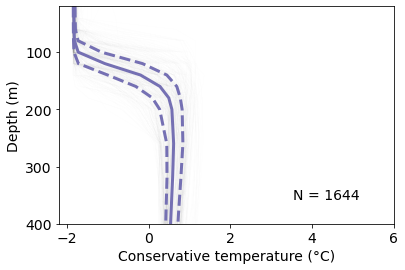

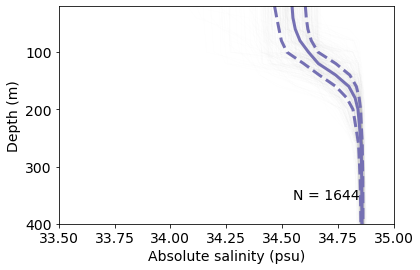

plot_tools.plot_many_profiles


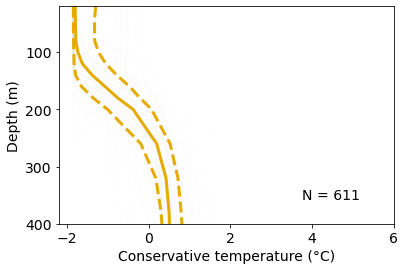

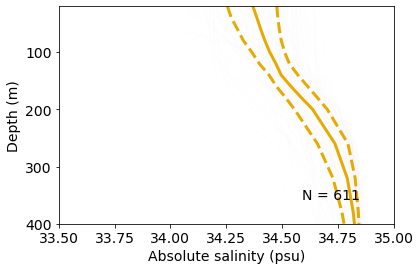

plot_tools.plot_many_profiles


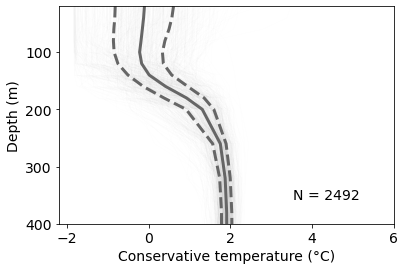

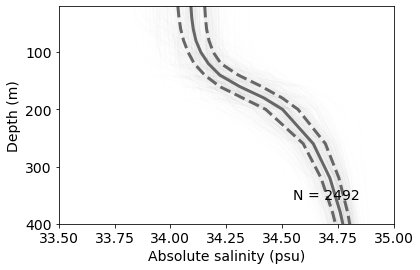

In [15]:
# plot T, S vertical structure of the classes
pt.plot_class_vertical_structures(ploc, dfp.where(dfp.season==4, drop=True), 
                                  n_components_selected, 
                                  colormap,
                                  zmin=zmin, 
                                  zmax=400,
                                  Tmin=Trange[0], 
                                  Tmax=Trange[1],
                                  Smin=Srange[0], 
                                  Smax=Srange[1],
                                  frac=0.25, 
                                  description='SON',
                                  withDensity=False)